In [ ]:
# imports
import math, random

# import gym
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# USE_CUDA = torch.cuda.is_available()
# Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    


In [ ]:
class MonkRNN(nn.Module):
    def __init__(self, inp_size=3, n_neurons=128, out_size=6, rnn_nonlinearity = 'relu'):
        super(MonkRNN, self).__init__()
        
        
        
        # simplify
        
        # input -> ReLU RNN -> Linear -> ReLU -> Linear -> Curl field and friction  -> output (velocity x, velocity y)
        
        # Loss - squared error with target velocity + l2 regularization on all parameters

        self.inp_size = inp_size
        self.out_size = out_size
        self.n_neurons = n_neurons
        self.init_hidden_state = nn.Parameter(torch.zeros(1, n_neurons))

        # Inputs are:
        
        # Recurrent layer parameters.
        self.rnn = nn.RNNCell(input_size=inp_size,hidden_size=n_neurons,nonlinearity=rnn_nonlinearity)
        # self.rnn = nn.GRUCell(inp_size,n_neurons)
#         self.rnn.weight_hh.data.normal_(0, 2 / np.sqrt(n_neurons))
#         self.out_layer = nn.Linear(n_neurons,out_size)
        # Output layer parameters
        self.out_layer = nn.Sequential(nn.Dropout(p=.2),nn.Linear(n_neurons, n_neurons), nn.ReLU(),nn.Linear(n_neurons, out_size))
#         self.out_layer[0].weight.data.normal_(0, 1.5 / np.sqrt(n_neurons))
#         self.out_layer[2].weight.data.normal_(0, 1.5 / np.sqrt(n_neurons))
        
        

    def forward(self, inp, curl, h_old=None):
        """
        Parameters
        ----------
        inp : torch.tensor
            Hand and target positions. Has shape (7,).
            (go, hand_x, hand_y, curr_tgx, curr_tgy, next_tgx, next_tgy)
        hidden : torch.tensor
            Initial firing rates. Has shape (n_neurons,)
        task_info : torch.tensor
            tensor holding (go, curr_tgx, curr_tgy, next_tgx, next_tgy)

        Returns
        -------
        acc : torch.tensor
            has shape (2,) corresponding to x and y acceleration.
        hiddens : torch.tensor
            has shape (n_neurons,) corresponding network activity.
        """


        # Update RNN one time step.
        h_new = self.rnn(inp, h_old)

        # Collect RNN output (acceleration of hand).
        dv = self.out_layer(h_new)
        
        dv = dv + curl
        
        
        # print("hidden {}, Acc {}".format(h_new, acc))
        return dv, h_new
    
   

In [ ]:
class GenerateInputTargetTimeseries():
    def __init__(self,curl=False):
        self.max_pos = 50
        self.min_pos = -50
        self.max_target_acc = 1
        self.go_cue = 'pulsed'
        self.Tx = 100
        self.T_on = 20
        self.T_off = 80
        self.max_go_delay = 10
        self.width_go_cue=5
        self.tau=3 # time constant for generating sigmoidal movements
        self.curl=curl
        self.curl_xlims = [-20,20]
        self.curl_xmag=-1
        self.curl_ymag = 0
        self.curl_ylims = [-5,50]

    def get_minibatch(self, m):
        """
        Parameters
        ----------
        m : int, minibatch size
        Returns
        -------
        X : torch.tensor
            has shape (m,3,Tx), 3 timeseries for target position and go signal
        Y : torch.tensor
            has shape (m,2,Tx), target acceleration timeseries 
        CURL : torch.tensor
            has shape (m,2,Tx), curl force applied 
        """
        
        
        # generate m target positions
        targ_pos = (self.max_pos-self.min_pos)*np.random.rand(m,2)+self.min_pos
        go_time = self.T_on + np.random.randint(self.max_go_delay,size=[m,1])
        
        
        # create input timeseries
        X = np.zeros((m,3,self.Tx))
        X[:,:2,self.T_on:self.T_off] = targ_pos[:,:,np.newaxis]
        for i in range(self.width_go_cue): # Start cue
            X[:,2,go_time.ravel()+i] = 10
        
        # create output timeseries
        t = np.linspace(0,self.Tx,num=self.Tx)[np.newaxis,np.newaxis,:]
#         print(targ_pos.shape,)
        pos = targ_pos[:,:,np.newaxis]/(1+np.exp(-(t-5*self.tau - go_time[:,:,np.newaxis])/self.tau))
        vel = 10*np.diff(pos,prepend=0)
        acc = 10*np.diff(vel,prepend=0)
        Y = np.zeros((m,6,self.Tx))
        Y[:,:2,:]=pos
        Y[:,2:4,:]=vel
        Y[:,4:,:]=acc
        # Y = np.diff(np.diff(pos,prepend=0),prepend=0)
        
        
#         curl forces
        CURL = np.zeros((m,6,self.Tx))
        # CURL = np.zeros((m,2,self.Tx))
        if self.curl:
            # apply x curl
            curlx = CURL[:,0,:]
            curlx[(pos[:,0,:]>=self.curl_xlims[0]) & (pos[:,0,:]<=self.curl_xlims[1])] = self.curl_xmag

            

            # apply y curl
            curly= CURL[:,1,:]
            curly[(pos[:,1,:]>=self.curl_ylims[0]) & (pos[:,1,:]<=self.curl_ylims[1])] = self.curl_xmag

            CURL[:,2,:]=np.cumsum(curlx,axis=-1)
            CURL[:,3,:]=np.cumsum(curly,axis=-1)

            CURL[:,4,:]=np.cumsum(np.cumsum(curlx,axis=-1),axis=-1)
            CURL[:,5,:]=np.cumsum(np.cumsum(curly,axis=-1),axis=-1)
        
        # create curl 
        return torch.from_numpy(X).to(device,dtype=torch.float), torch.from_numpy(Y).to(device,dtype=torch.float), torch.from_numpy(CURL).to(device,dtype=torch.float)

In [ ]:
dataclass = GenerateInputTargetTimeseries(curl=True)
X,Y,CURL= dataclass.get_minibatch(10)

In [57]:
print(X.shape,Y.shape,CURL.shape)

torch.Size([10, 3, 100]) torch.Size([10, 6, 100]) torch.Size([10, 6, 100])


In [58]:
# Define transformations.
rnn = MonkRNN()
rnn.to(device)
data_gen = GenerateInputTargetTimeseries(curl=False)
optimizer = torch.optim.Adam(rnn.parameters(), lr =1E-3,weight_decay=0.00)

N_TRAIN_EPOCHS = 1000
BATCH_SIZE=32
LAM=0.00
LLAM=0.00
## TRAIN NETWORK ##
X,Y,CURL = data_gen.get_minibatch(BATCH_SIZE)
losses = []

for epoch in range(int(N_TRAIN_EPOCHS)):
    
    clear_output(True)
    
        
#         f,ax = plt.subplots()
#         ax.plot(losses)
    # Zero out the gradient
    X,Y,CURL = data_gen.get_minibatch(BATCH_SIZE)
    optimizer.zero_grad()

    
    
    
    # Now simulate the trial
    H_all = torch.zeros(BATCH_SIZE,rnn.n_neurons,data_gen.Tx,dtype=torch.float).to(device)
    h= torch.zeros(BATCH_SIZE,rnn.n_neurons,dtype=torch.float).to(device)
    YHAT = torch.from_numpy(np.zeros(Y.shape)).to(device)
    for t in range(data_gen.Tx):
#         print(t,X[:,:,t],h)
        # Update the RNN activity
        dv, h = rnn.forward(X[:,:,t], CURL[:,:,t], h_old=h)
        H_all[:,:,t]=h
        YHAT[:,:,t]=dv

    # Compute loss, and do backprop.
    V,VHAT = torch.cumsum(Y,dim=2),torch.cumsum(YHAT,dim=2)
    D,DHAT = torch.cumsum(V,dim=2),torch.cumsum(VHAT,dim=2)
    DIFF1 = YHAT[:,:,1:]-YHAT[:,:,:-1]
    
    loss = (Y - YHAT).pow(2).mean() + LAM*H_all.pow(2).mean() + LLAM*((DIFF1[:,:,1:]-DIFF1[:,:,:-1])).pow(2).mean() #+ 10*(V-VHAT).pow(2).mean() + 100*(D-DHAT).pow(2).mean()
    if epoch%10==0:
        print(epoch,loss)
    loss.backward()
    losses.append(loss.item())
    # Update the weights
    optimizer.step()



990 tensor(26.4944, dtype=torch.float64, grad_fn=<AddBackward0>)


In [33]:
data_gen = GenerateInputTargetTimeseries(curl=True)

for epoch in range(int(N_TRAIN_EPOCHS)):
    
    clear_output(True)
    
        
#         f,ax = plt.subplots()
#         ax.plot(losses)
    # Zero out the gradient
    X,Y,CURL = data_gen.get_minibatch(BATCH_SIZE)
    optimizer.zero_grad()

    
    
    
    # Now simulate the trial
    H_all = torch.zeros(BATCH_SIZE,rnn.n_neurons,data_gen.Tx,dtype=torch.float)
    h= torch.zeros(BATCH_SIZE,rnn.n_neurons,dtype=torch.float)
    YHAT = torch.from_numpy(np.zeros(Y.shape)).to(device)
    for t in range(data_gen.Tx):
#         print(t,X[:,:,t],h)
        # Update the RNN activity
        dv, h = rnn.forward(X[:,:,t], CURL[:,:,t], h_old=h)
        H_all[:,:,t]=h
        YHAT[:,:,t]=dv

    # Compute loss, and do backprop.
    V,VHAT = torch.cumsum(Y,dim=2),torch.cumsum(YHAT,dim=2)
    D,DHAT = torch.cumsum(V,dim=2),torch.cumsum(VHAT,dim=2)
    DIFF1 = YHAT[:,:,1:]-YHAT[:,:,:-1]
    
    loss = (Y - YHAT).pow(2).mean() + LAM*H_all.pow(2).mean() + LLAM*((DIFF1[:,:,1:]-DIFF1[:,:,:-1])).pow(2).mean() #+ 10*(V-VHAT).pow(2).mean() + 100*(D-DHAT).pow(2).mean()
    if epoch%10==0:
        print(epoch,loss)
    loss.backward()
    losses.append(loss.item())
    # Update the weights
    optimizer.step()



990 tensor(41070.3061, dtype=torch.float64, grad_fn=<AddBackward0>)


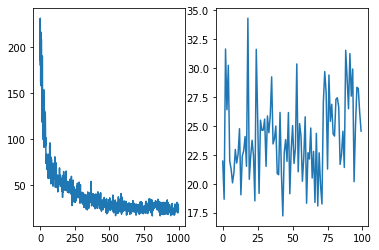

In [59]:
f,ax = plt.subplots(1,2)
ax[0].plot(losses)
ax[1].plot(losses[-100:])


In [23]:
print(losses[-10:])

[18.932763332830554, 21.642353710524183, 19.903965215293663, 30.135294659553463, 22.790039343695128, 20.802906118283737, 20.266053381428144, 21.123543970681652, 23.676001862983693, 23.12365229296886]


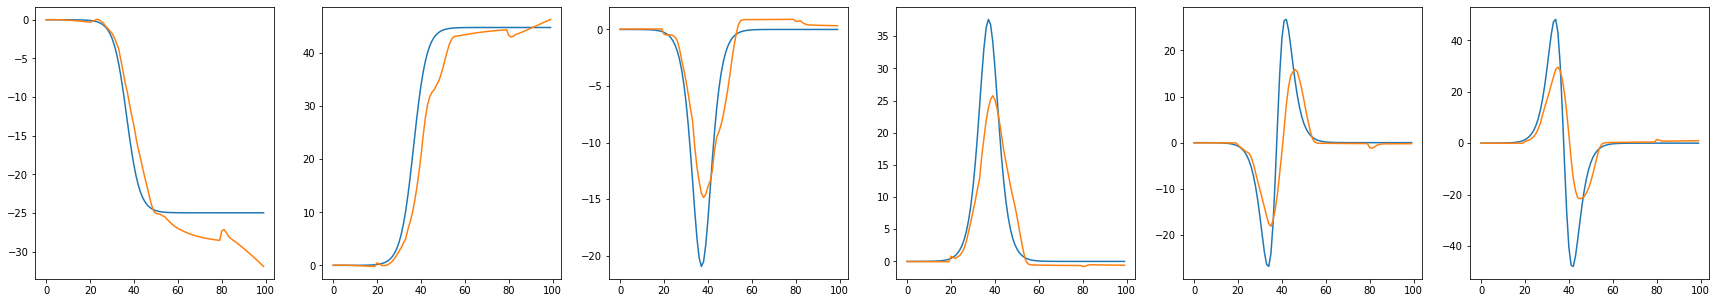

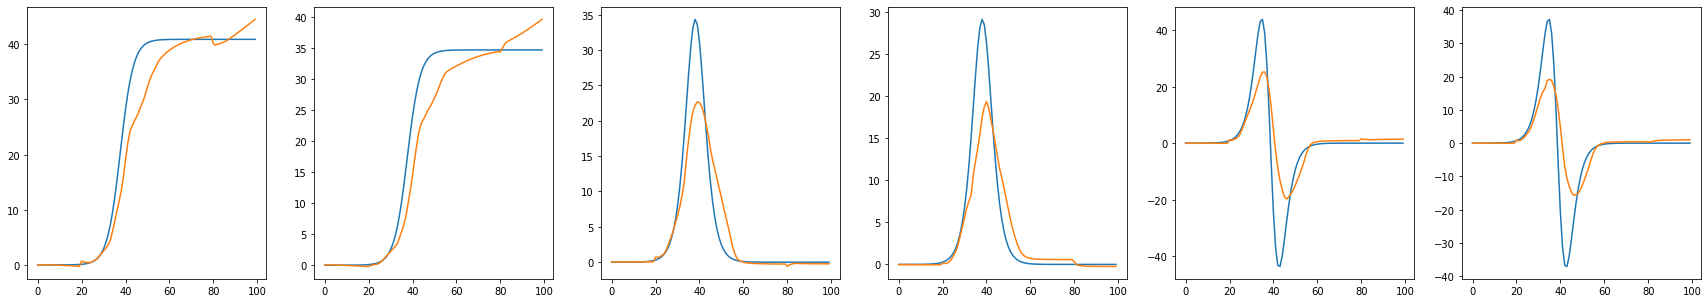

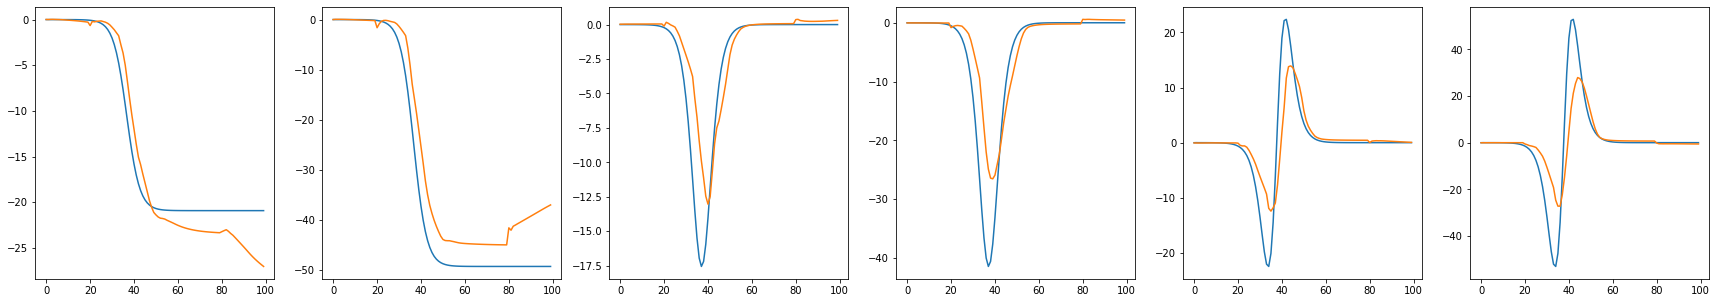

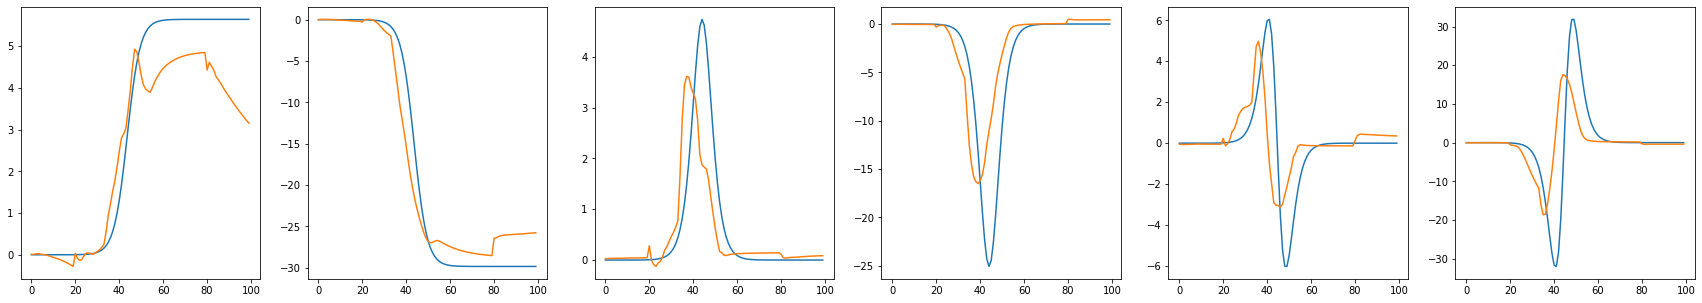

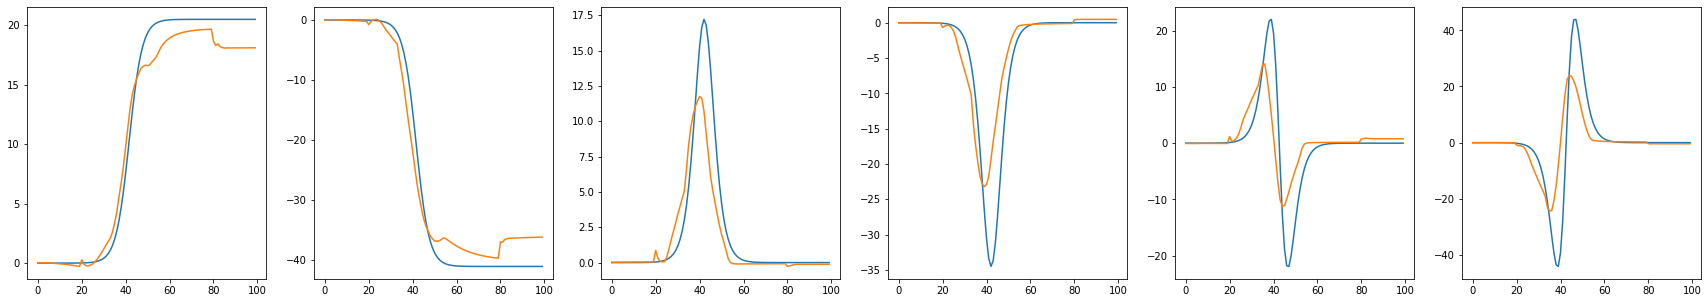

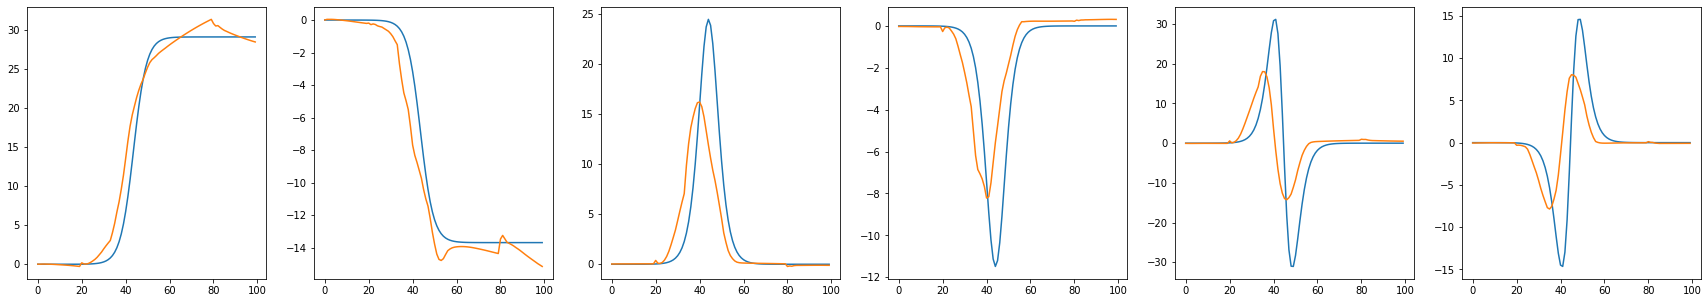

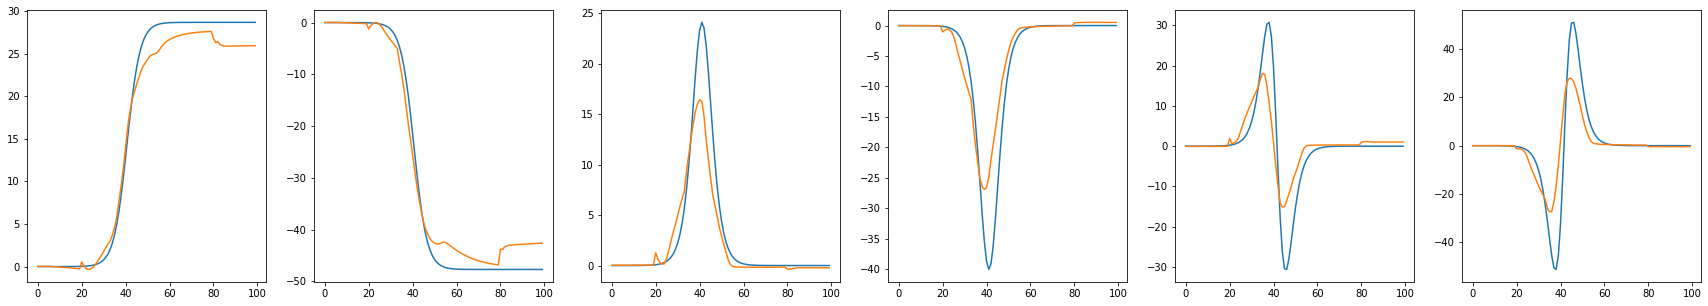

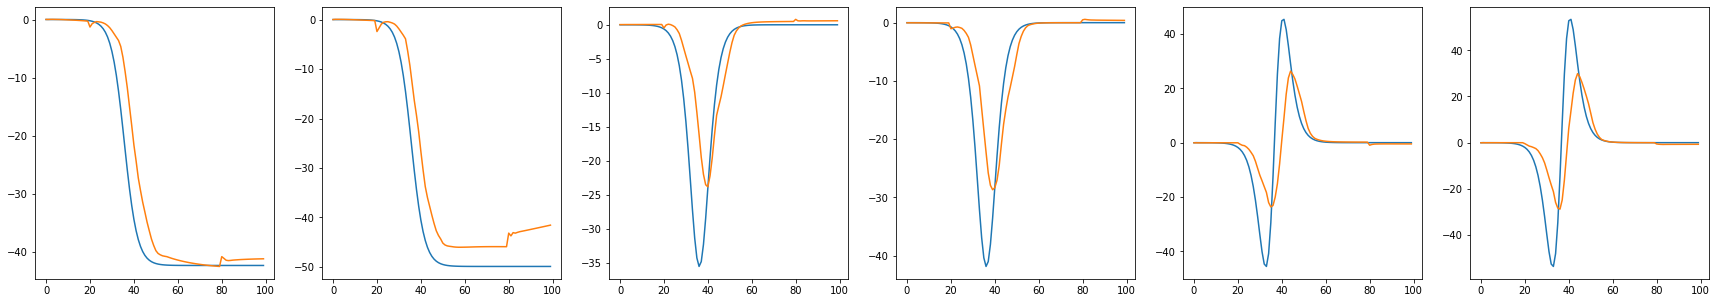

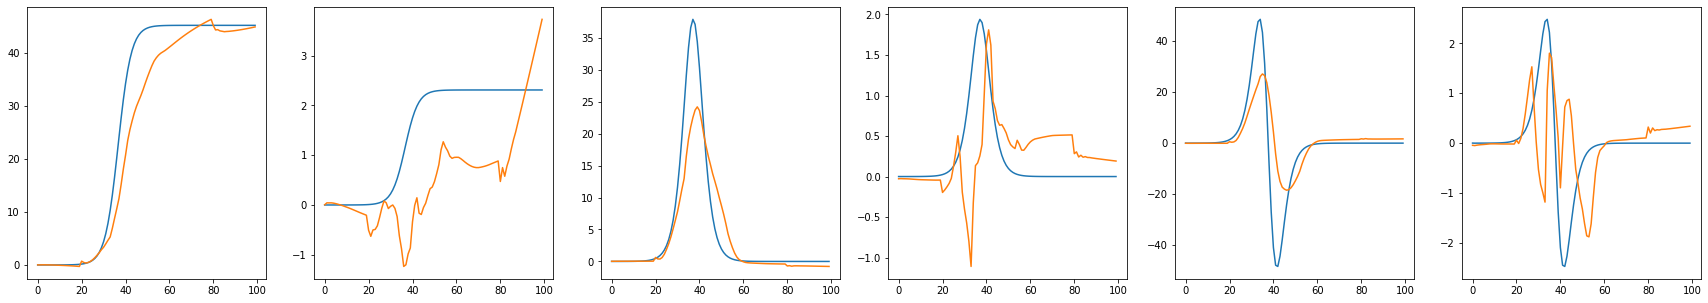

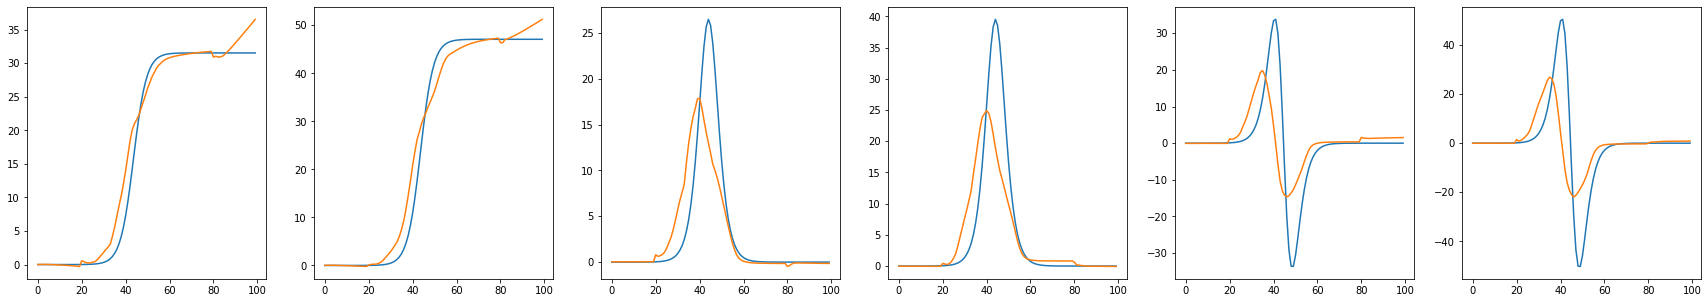

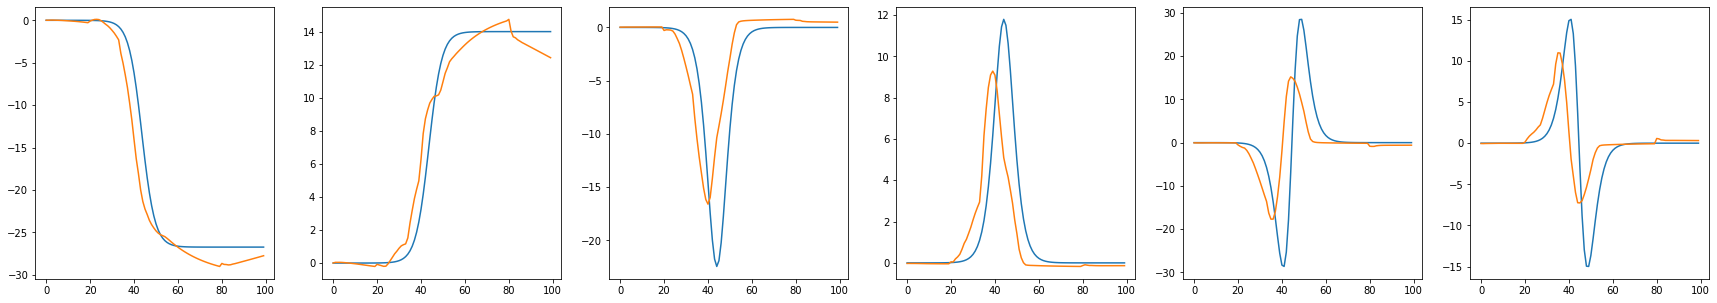

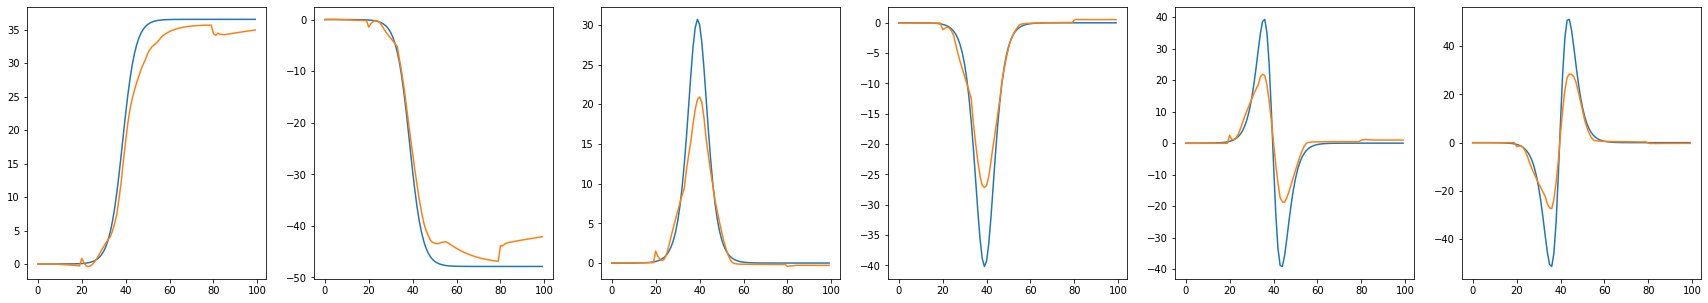

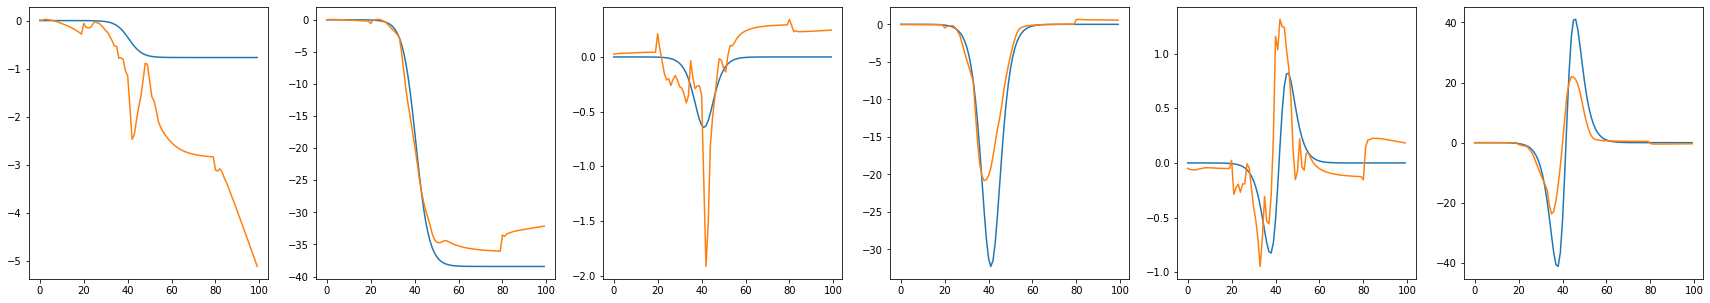

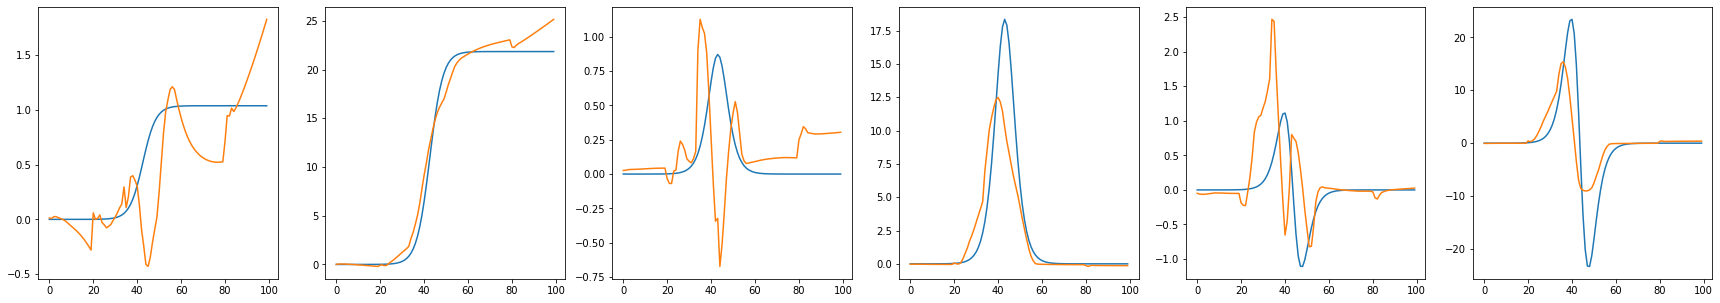

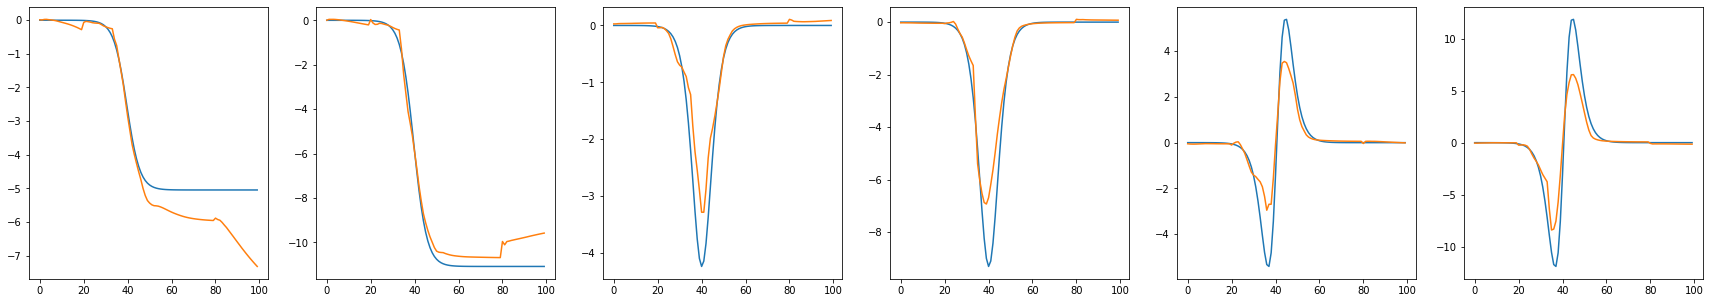

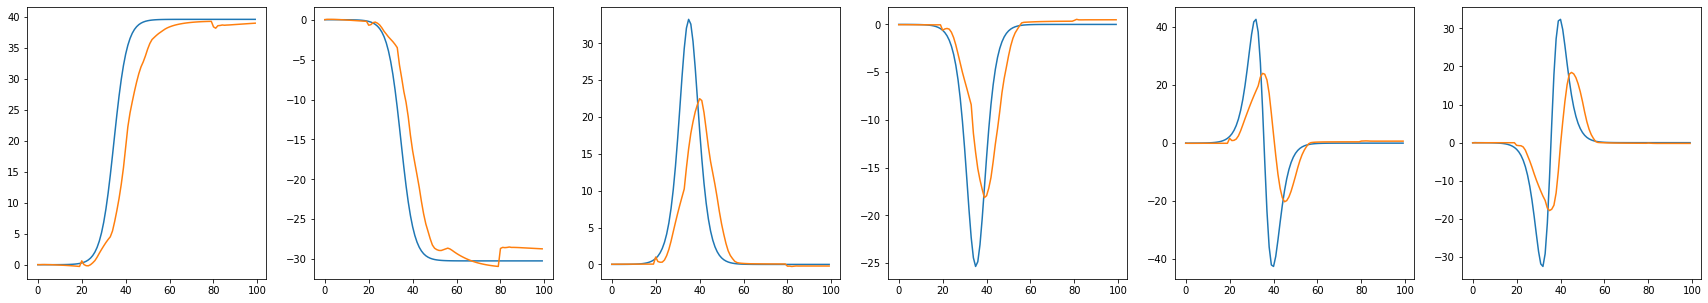

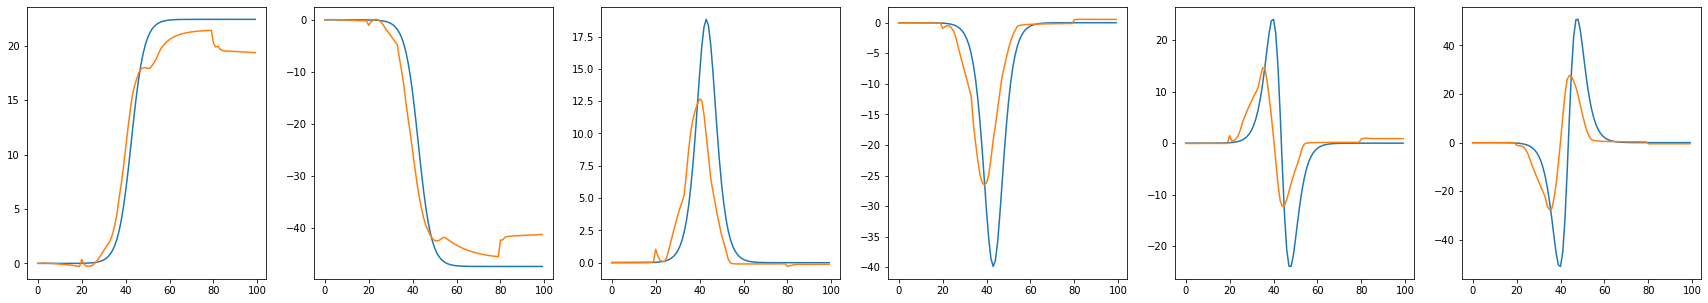

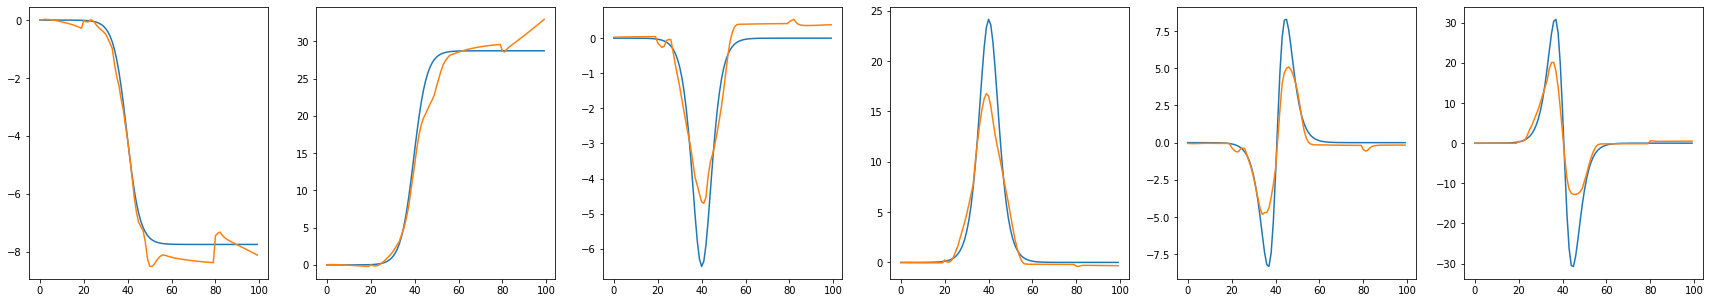

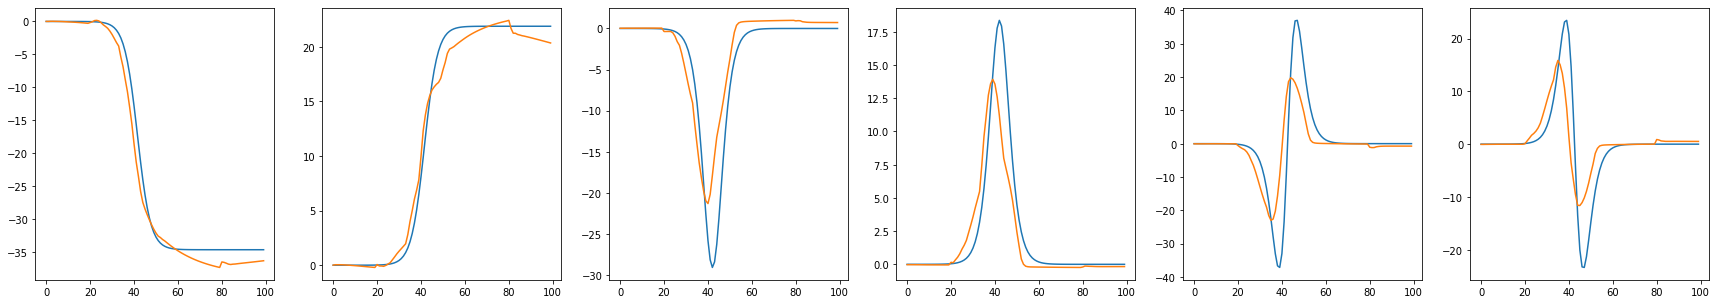

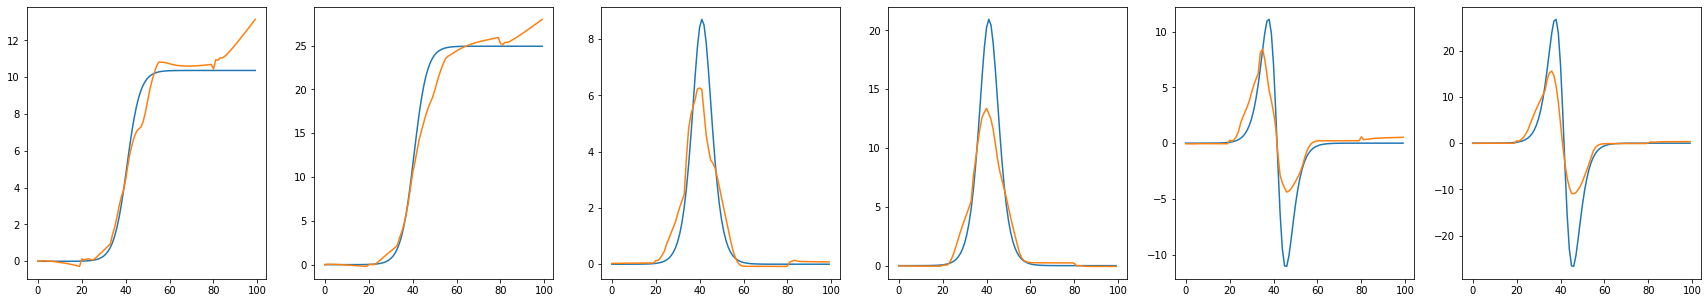

In [60]:
Xtest,Ytest,CURLtest = data_gen.get_minibatch(20)
for i in range(20):
#    
    YHATtest =np.zeros(Ytest.shape)
    h= torch.zeros(20,rnn.n_neurons,dtype=torch.float)
    for t in range(data_gen.Tx):
#         print(t,X[:,:,t],h)
        # Update the RNN activity
        
        with torch.no_grad():
            rnn.eval()
            dv, h = rnn.forward(Xtest[:,:,t], CURLtest[:,:,t], h_old=h)
        YHATtest[:,:,t]=dv
    f,ax = plt.subplots(1,6,figsize=[30,5])
    ax[0].plot(Ytest[i,0,:])
    ax[0].plot(YHATtest[i,0,:])
    ax[2].plot(Ytest[i,2,:])
    ax[2].plot(YHATtest[i,2,:])
    ax[4].plot(Ytest[i,4,:])
    ax[4].plot(YHATtest[i,4,:])


    # ax[2].plot(torch.cumsum(Ytest[i,0,:],-1))
    # ax[2].plot(np.cumsum(YHATtest[i,0,:],-1))
    # ax[4].plot(torch.cumsum(torch.cumsum(Ytest[i,0,:],-1),-1))
    # ax[4].plot(np.cumsum(np.cumsum(YHATtest[i,0,:],-1),-1))


    # ax[0].plot(YHATtest[i,0,:])
    ax[1].plot(Ytest[i,1,:])
    ax[1].plot(YHATtest[i,1,:])

    ax[3].plot(Ytest[i,3,:])
    ax[3].plot(YHATtest[i,3,:])
    ax[5].plot(Ytest[i,5,:])
    ax[5].plot(YHATtest[i,5,:])

#     ax[3].plot(torch.cumsum(Ytest[i,1,:],-1))
#     ax[3].plot(np.cumsum(YHATtest[i,1,:],-1))

#     ax[4].plot(torch.cumsum(torch.cumsum(Ytest[i,1,:],-1),-1))
#     ax[4].plot(np.cumsum(np.cumsum(YHATtest[i,1,:],-1),-1))
# # print((YHATtest-Ytest).pow(2).mean())